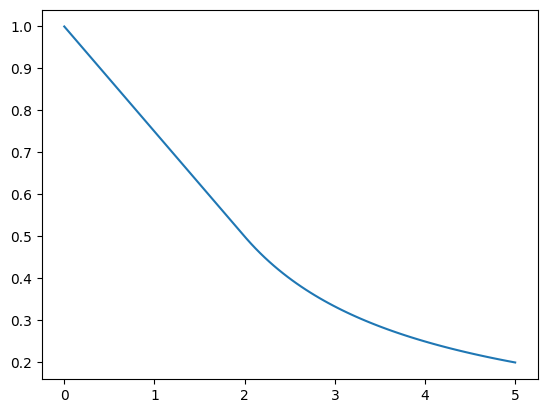

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
def piecewise_function(x, x0):
    condition = x > x0
    f_x = torch.where(condition, 1/x, -(x - 2*x0) / x0**2)
    return f_x

# 示例输入
x0 = 2.0

x = torch.tensor(np.linspace(0, 5, 100))
y = piecewise_function(x, x0)
plt.plot(x,y)

In [ ]:
"""
    Only supports the time series datasets! (model definition assumes it's 2d problem here)
    (the train numbers and test numbers should not be predefined in the dataset, otherwise merge the dataset)
    the predicted feature now only support 1 channel
    logger currently only supports tensorboard 
    TODO: support more channels
"""
import torch
import numpy as np

from neuralop.models import FNO
# from neuralop.training import OutputEncoderCallback
from neuralop.utils import count_params
from neuralop import LpLoss, H1Loss
from neuralop.datasets.autoregressive_dataset import load_autoregressive_traintestsplit_v3
from neuralop.training import MultipleInputCallback, SimpleTensorBoardLoggerCallback, ModelCheckpointCallback

import os
import sys
import time
from pathlib import Path
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

import argparse

def get_parser():
    parser = argparse.ArgumentParser('FNO Models', add_help=False)
    parser.add_argument('--model', type=str, default='FNO')
    parser.add_argument('--model_name',  type=str, default='FNO')
    # # # Data Loader Configs # # #
    parser.add_argument('--n_train', type=int, default=2)
    parser.add_argument('--n_test', nargs='+', type=int, default=1)
    parser.add_argument('--batch_size', type=int, default=32) #
    parser.add_argument('--test_batch_size', type=int, default=128)
    parser.add_argument('--train_subsample_rate', type=int, default=4)
    parser.add_argument('--test_subsample_rate', nargs='+',  type=int, default=4)
    parser.add_argument('--time_step', type=int, default=10)
    parser.add_argument('--predict_feature', type=str, default='u')
    parser.add_argument('--data_path', type=str, default='./data/ns_random_forces_1.h5', help="the path of data file")
    parser.add_argument('--test_data_path', nargs='+', type=str, default='', help="the path of test data file")
    parser.add_argument('--data_name', type=str, default='NS_Contextual', help="the name of dataset")
    parser.add_argument('--simaug_train_data', type=bool, default=False, help="whether to augment the dataset with similar ones")
    parser.add_argument('--simaug_test_data', type=bool, default=False, help="whether to augment the test dataset with similar ones")
    # # # Model Configs # # #
    parser.add_argument('--n_modes', type=int, default=21) #
    parser.add_argument('--num_prod', type=int, default=2) #
    parser.add_argument('--n_layers', type=int, default=4) ##
    parser.add_argument('--raw_in_channels', type=int, default=3, help='TorusLi: 1; ns_contextual: 3')
    parser.add_argument('--pos_encoding', type=bool, default=True) ##
    parser.add_argument('--hidden_channels', type=int, default=32) #
    parser.add_argument('--lifting_channels', type=int, default=256) #
    parser.add_argument('--projection_channels', type=int, default=64) #
    parser.add_argument('--factorization', type=str, default='tucker') #####
    parser.add_argument('--channel_mixing', type=str, default='', help='') #####
    parser.add_argument('--rank', type=float, default=0.42, help='the compression rate of tensor') #
    parser.add_argument('--load_path', type=str, default='', help='load checkpoint')

    # # # Optimizer Configs # # #
    parser.add_argument('--lr', type=float, default=1e-3) #Path
    parser.add_argument('--weight_decay', type=float, default=1e-4) #
    parser.add_argument('--scheduler_steps', type=int, default=100) #
    parser.add_argument('--scheduler_gamma', type=float, default=0.5) #
    parser.add_argument('--train_loss', type=str, default='h1', help='h1 or l2') #
    # # # Log and Save Configs # # #
    parser.add_argument('--log_path', type=str, default='./runs')
    parser.add_argument('--save_path', type=str, default='./ckpt')
    parser.add_argument('--prefix', type=str, default='', help='prefix of log and save file')
    parser.add_argument('--time_suffix', type=bool, default=True, help='whether to use program start time as suffix')
    parser.add_argument('--config_details', type=bool, default=True, help='whether to include config details to the log and save file name')
    parser.add_argument('--log_interval', type=int, default=4)
    parser.add_argument('--save_interval', type=int, default=20)
    # # # Trainer Configs # # #
    parser.add_argument('--epochs', type=int, default=501) #
    parser.add_argument('--verbose', type=bool, default=True)
    parser.add_argument('--random_seed', type=bool, default=False)
    parser.add_argument('--seed', type=int, default=0)

    return parser

def run(args):
    seed = args.seed
    if args.random_seed:
        import random
        seed = random.randint(1, 10000)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    verbose = args.verbose
    # # # Data Preparation # # #
    n_train = args.n_train
    n_test = args.n_test
    batch_size = args.batch_size
    test_batch_size = args.test_batch_size
    train_subsample_rate = args.train_subsample_rate
    test_subsample_rate = args.test_subsample_rate
    time_step = args.time_step
    data_path = args.data_path
    train_loader, test_loaders = load_autoregressive_traintestsplit_v3(
        data_path,
        n_train, n_test,
        batch_size, test_batch_size,
        train_subsample_rate, test_subsample_rate,
        time_step,
        test_data_paths=args.test_data_path,
        predict_feature=args.predict_feature,
        append_positional_encoding=args.pos_encoding
    )
    resolution = train_loader.dataset[0]['x'].shape[0]

    # # # Model Definition # # #
    n_modes=args.n_modes
    num_prod=args.num_prod
    in_channels = args.raw_in_channels
    if args.pos_encoding:
        in_channels += 2
    model = FNO(in_channels=in_channels, n_modes=(n_modes, n_modes), hidden_channels=args.hidden_channels, lifting_channels=args.lifting_channels,
                projection_channels=args.projection_channels, n_layers=args.n_layers, factorization=args.factorization, channel_mixing=args.channel_mixing, rank=args.rank, num_prod=num_prod)
    
    if args.load_path != '':
        model.load_state_dict(torch.load(args.load_path))

    model = model.to(device)

    n_params = count_params(model)
    print(f'\nOur model has {n_params} parameters.')
    sys.stdout.flush()

    # # # Optimizer Definition # # #
    optimizer = torch.optim.Adam(model.parameters(), 
                                    lr=args.lr, 
                                    weight_decay=args.weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.scheduler_steps, gamma=args.scheduler_gamma)

    # # # Loss Definition # # #
    l2loss = LpLoss(d=2, p=2)
    h1loss = H1Loss(d=2)

    if args.train_loss == 'h1':
        train_loss = h1loss
    elif args.train_loss == 'l2':
        train_loss = l2loss
    else: assert False, "Unsupported training loss!"
    eval_losses={'h1': h1loss, 'l2': l2loss}

    if verbose:
        print('\n### MODEL ###\n', model)
        print('\n### OPTIMIZER ###\n', optimizer)
        print('\n### SCHEDULER ###\n', scheduler)
        print('\n### LOSSES ###')
        print(f'\n * Train: {train_loss}')
        print(f'\n * Test: {eval_losses}')
        sys.stdout.flush()

    # # # Logs and Saves Definition (path and file name) # # #
    if not os.path.exists(args.log_path):
        os.makedirs(args.log_path)
    if not os.path.exists(args.save_path):
        os.makedirs(args.save_path)
    file_name = f'{args.data_name}_{args.model_name}'
    prefix = args.prefix
    if prefix != '': file_name = file_name + '_' + prefix
    # config_name = ''
    config_file_path=''
    if args.config_details:
        # config_name = f'_b{args.batch_size}_mode{args.n_modes}_prod{args.num_prod}_layer{args.n_layers}_hid{args.hidden_channels}_lift{args.lifting_channels}_proj{args.projection_channels}_fact-{args.factorization}_rank{args.rank}_mix-{args.channel_mixing}_pos-enc-{args.pos_encoding}_lr{args.lr}_wd{args.weight_decay}_sche-step{args.scheduler_steps}_gamma{args.scheduler_gamma}_loss{args.train_loss}'
        config_file_path = f"/timestep_{args.time_step}/layer_{args.n_layers}/fact-{args.factorization}/rank_{args.rank}/mix-{args.channel_mixing}/prod_{args.num_prod}/pos-enc-{args.pos_encoding}/loss-{args.train_loss}/mode_{args.n_modes}/hid_{args.hidden_channels}/lift_{args.lifting_channels}/proj_{args.projection_channels}/b_{args.batch_size}/lr_{args.lr}/wd_{args.weight_decay}/sche-step_{args.scheduler_steps}/gamma_{args.scheduler_gamma}/simaug_train_data_{args.simaug_train_data}/"
    time_name = ''
    if args.time_suffix:
        localtime = time.localtime(time.time())
        time_name = f"{localtime.tm_mon}-{localtime.tm_mday}-{localtime.tm_hour}-{localtime.tm_min}"
    # file_name = file_name + config_name + time_name
    file_name = file_name + config_file_path + time_name

    log_dir = args.log_path
    if log_dir[-1]!='/': log_dir = log_dir + '/'
    log_dir = log_dir + file_name
    save_dir = args.save_path
    if save_dir[-1]!='/': save_dir = save_dir + '/'
    save_dir = save_dir + file_name

    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    log_dir = Path(log_dir)
    save_dir = Path(save_dir)

    # # # Trainer Definition # # #
    from scripts.ns_contextual_trainer import ns_contextual_trainer

    trainer = ns_contextual_trainer(model=model, n_epochs=args.epochs,
                    device=device,
                    simaug_test_data=args.simaug_test_data,
                    simaug_train_data=args.simaug_train_data,
                    callbacks=[SimpleTensorBoardLoggerCallback(log_dir=log_dir),
                               ModelCheckpointCallback(
                                checkpoint_dir=save_dir,
                                interval=args.save_interval)],
                    scaling_ks=[1,], scaling_ps=[4,8,16],
                    wandb_log=False,
                    log_test_interval=args.log_interval,
                    use_distributed=False,
                    verbose=True)

    trainer.train(train_loader=train_loader,
                test_loaders=test_loaders,
                optimizer=optimizer, 
                scheduler=scheduler, 
                regularizer=False, 
                training_loss=train_loss, 
                eval_losses=eval_losses)

    return

if __name__ == '__main__':
    parser = get_parser()
    args = parser.parse_args()
    run(args)

In [1]:
# path = '/home/yichen/repo/cfd/myNeuralOperator/ckpt/TorusLi_LSM/width_32/pos-enc-True/num_token4/num_basis_12/patch_size_4,4/padding_0,0/loss-h1/b_20/lr_0.001/wd_0.0001/sche-step_100/gamma_0.5/5-17-22-3/ep_480.pt'
import torch
path = '/home/yichen/repo/cfd/myNeuralOperator/ckpt/NS_Contextual_Fewshot_LSM/width_32/pos-enc-True/num_token4/num_basis_12/patch_size_4,4/padding_0,0/mix-/loss-h1/b_64/lr_0.001/wd_0.0001/sche-step_100/gamma_0.5/5-20-17-26/ep_480.pt'
state_dict = torch.load(path)

In [2]:
# state_dict['process4.encoder_attn.weight'].shape
state_dict['process4.encoder_attn.linear.fcs.0.weight'].shape

KeyError: 'process4.encoder_attn.linear.fcs.0.weight'

In [3]:
state_dict.keys()

odict_keys(['inc.double_conv.0.weight', 'inc.double_conv.1.weight', 'inc.double_conv.1.bias', 'inc.double_conv.1.running_mean', 'inc.double_conv.1.running_var', 'inc.double_conv.1.num_batches_tracked', 'inc.double_conv.3.weight', 'inc.double_conv.4.weight', 'inc.double_conv.4.bias', 'inc.double_conv.4.running_mean', 'inc.double_conv.4.running_var', 'inc.double_conv.4.num_batches_tracked', 'down1.maxpool_conv.1.double_conv.0.weight', 'down1.maxpool_conv.1.double_conv.1.weight', 'down1.maxpool_conv.1.double_conv.1.bias', 'down1.maxpool_conv.1.double_conv.1.running_mean', 'down1.maxpool_conv.1.double_conv.1.running_var', 'down1.maxpool_conv.1.double_conv.1.num_batches_tracked', 'down1.maxpool_conv.1.double_conv.3.weight', 'down1.maxpool_conv.1.double_conv.4.weight', 'down1.maxpool_conv.1.double_conv.4.bias', 'down1.maxpool_conv.1.double_conv.4.running_mean', 'down1.maxpool_conv.1.double_conv.4.running_var', 'down1.maxpool_conv.1.double_conv.4.num_batches_tracked', 'down2.maxpool_conv.1.do

odict_keys(['inc.double_conv.0.weight', 'inc.double_conv.1.weight', 'inc.double_conv.1.bias', 'inc.double_conv.1.running_mean', 'inc.double_conv.1.running_var', 'inc.double_conv.1.num_batches_tracked', 'inc.double_conv.3.weight', 'inc.double_conv.4.weight', 'inc.double_conv.4.bias', 'inc.double_conv.4.running_mean', 'inc.double_conv.4.running_var', 'inc.double_conv.4.num_batches_tracked', 'down1.maxpool_conv.1.double_conv.0.weight', 'down1.maxpool_conv.1.double_conv.1.weight', 'down1.maxpool_conv.1.double_conv.1.bias', 'down1.maxpool_conv.1.double_conv.1.running_mean', 'down1.maxpool_conv.1.double_conv.1.running_var', 'down1.maxpool_conv.1.double_conv.1.num_batches_tracked', 'down1.maxpool_conv.1.double_conv.3.weight', 'down1.maxpool_conv.1.double_conv.4.weight', 'down1.maxpool_conv.1.double_conv.4.bias', 'down1.maxpool_conv.1.double_conv.4.running_mean', 'down1.maxpool_conv.1.double_conv.4.running_var', 'down1.maxpool_conv.1.double_conv.4.num_batches_tracked', 'down2.maxpool_conv.1.double_conv.0.weight', 'down2.maxpool_conv.1.double_conv.1.weight', 'down2.maxpool_conv.1.double_conv.1.bias', 'down2.maxpool_conv.1.double_conv.1.running_mean', 'down2.maxpool_conv.1.double_conv.1.running_var', 'down2.maxpool_conv.1.double_conv.1.num_batches_tracked', 'down2.maxpool_conv.1.double_conv.3.weight', 'down2.maxpool_conv.1.double_conv.4.weight', 'down2.maxpool_conv.1.double_conv.4.bias', 'down2.maxpool_conv.1.double_conv.4.running_mean', 'down2.maxpool_conv.1.double_conv.4.running_var', 'down2.maxpool_conv.1.double_conv.4.num_batches_tracked', 'down3.maxpool_conv.1.double_conv.0.weight', 'down3.maxpool_conv.1.double_conv.1.weight', 'down3.maxpool_conv.1.double_conv.1.bias', 'down3.maxpool_conv.1.double_conv.1.running_mean', 'down3.maxpool_conv.1.double_conv.1.running_var', 'down3.maxpool_conv.1.double_conv.1.num_batches_tracked', 'down3.maxpool_conv.1.double_conv.3.weight', 'down3.maxpool_conv.1.double_conv.4.weight', 'down3.maxpool_conv.1.double_conv.4.bias', 'down3.maxpool_conv.1.double_conv.4.running_mean', 'down3.maxpool_conv.1.double_conv.4.running_var', 'down3.maxpool_conv.1.double_conv.4.num_batches_tracked', 'down4.maxpool_conv.1.double_conv.0.weight', 'down4.maxpool_conv.1.double_conv.1.weight', 'down4.maxpool_conv.1.double_conv.1.bias', 'down4.maxpool_conv.1.double_conv.1.running_mean', 'down4.maxpool_conv.1.double_conv.1.running_var', 'down4.maxpool_conv.1.double_conv.1.num_batches_tracked', 'down4.maxpool_conv.1.double_conv.3.weight', 'down4.maxpool_conv.1.double_conv.4.weight', 'down4.maxpool_conv.1.double_conv.4.bias', 'down4.maxpool_conv.1.double_conv.4.running_mean', 'down4.maxpool_conv.1.double_conv.4.running_var', 'down4.maxpool_conv.1.double_conv.4.num_batches_tracked', 'up1.conv.double_conv.0.weight', 'up1.conv.double_conv.1.weight', 'up1.conv.double_conv.1.bias', 'up1.conv.double_conv.1.running_mean', 'up1.conv.double_conv.1.running_var', 'up1.conv.double_conv.1.num_batches_tracked', 'up1.conv.double_conv.3.weight', 'up1.conv.double_conv.4.weight', 'up1.conv.double_conv.4.bias', 'up1.conv.double_conv.4.running_mean', 'up1.conv.double_conv.4.running_var', 'up1.conv.double_conv.4.num_batches_tracked', 'up2.conv.double_conv.0.weight', 'up2.conv.double_conv.1.weight', 'up2.conv.double_conv.1.bias', 'up2.conv.double_conv.1.running_mean', 'up2.conv.double_conv.1.running_var', 'up2.conv.double_conv.1.num_batches_tracked', 'up2.conv.double_conv.3.weight', 'up2.conv.double_conv.4.weight', 'up2.conv.double_conv.4.bias', 'up2.conv.double_conv.4.running_mean', 'up2.conv.double_conv.4.running_var', 'up2.conv.double_conv.4.num_batches_tracked', 'up3.conv.double_conv.0.weight', 'up3.conv.double_conv.1.weight', 'up3.conv.double_conv.1.bias', 'up3.conv.double_conv.1.running_mean', 'up3.conv.double_conv.1.running_var', 'up3.conv.double_conv.1.num_batches_tracked', 'up3.conv.double_conv.3.weight', 'up3.conv.double_conv.4.weight', 'up3.conv.double_conv.4.bias', 'up3.conv.double_conv.4.running_mean', 'up3.conv.double_conv.4.running_var', 'up3.conv.double_conv.4.num_batches_tracked', 'up4.conv.double_conv.0.weight', 'up4.conv.double_conv.1.weight', 'up4.conv.double_conv.1.bias', 'up4.conv.double_conv.1.running_mean', 'up4.conv.double_conv.1.running_var', 'up4.conv.double_conv.1.num_batches_tracked', 'up4.conv.double_conv.3.weight', 'up4.conv.double_conv.4.weight', 'up4.conv.double_conv.4.bias', 'up4.conv.double_conv.4.running_mean', 'up4.conv.double_conv.4.running_var', 'up4.conv.double_conv.4.num_batches_tracked', 'outc.conv.weight', 'outc.conv.bias', 'process1.weights', 'process1.latent', 'process1.encoder_attn.weight', 'process1.encoder_attn.bias', 'process1.decoder_attn.weight', 'process1.decoder_attn.bias', 'process2.weights', 'process2.latent', 'process2.encoder_attn.weight', 'process2.encoder_attn.bias', 'process2.decoder_attn.weight', 'process2.decoder_attn.bias', 'process3.weights', 'process3.latent', 'process3.encoder_attn.weight', 'process3.encoder_attn.bias', 'process3.decoder_attn.weight', 'process3.decoder_attn.bias', 'process4.weights', 'process4.latent', 'process4.encoder_attn.weight', 'process4.encoder_attn.bias', 'process4.decoder_attn.weight', 'process4.decoder_attn.bias', 'process5.weights', 'process5.latent', 'process5.encoder_attn.weight', 'process5.encoder_attn.bias', 'process5.decoder_attn.weight', 'process5.decoder_attn.bias', 'fc0.weight', 'fc0.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])
